<a href="https://colab.research.google.com/github/paramphy/sem-image-classification-using-CNN/blob/master/keras_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Epoch naming credentials


last_epoch =   278#@param {type: "number"}
new_epoch_index = 28  #@param {type: "number"}

#@markdown ---

# Importing Required Libreries

In [ ]:
root = "/content/gdrive/My Drive/Densenet121/densenet121_save_at_"
weights = root + str(last_epoch) + ".h5"
print(weights)
checkpoint_path = root + str(new_epoch_index) +"{epoch}.h5"
print(checkpoint_path)

In [ ]:
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
import datetime, os

# Accuaring Data from Drive 

In [ ]:
image_size = (150, 150)
batch_size = 32
 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/NANOML",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/NANOML",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 18577 files belonging to 10 classes.
Using 14862 files for training.
Found 18577 files belonging to 10 classes.
Using 3715 files for validation.


# Visualization of data

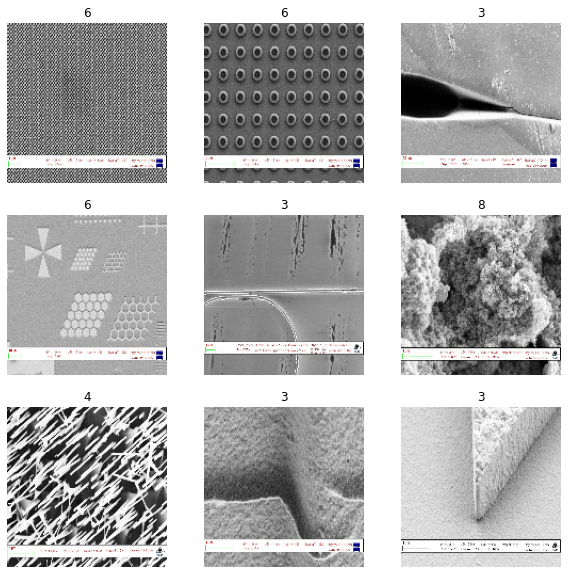

In [ ]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## Visualizing Augmented data

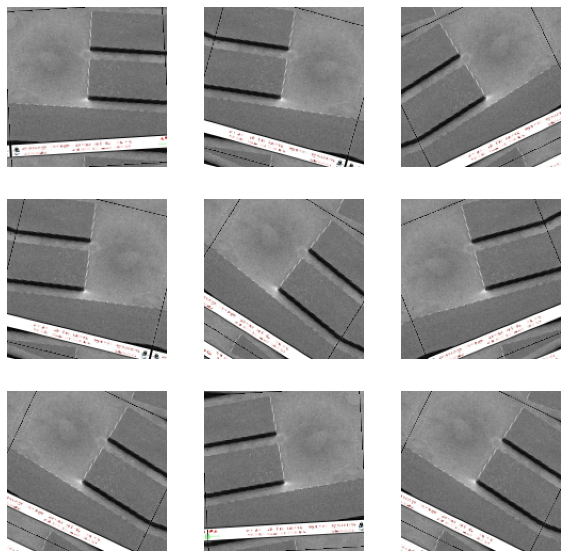

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Model Creation

##Data Prefetch

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

##Model

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

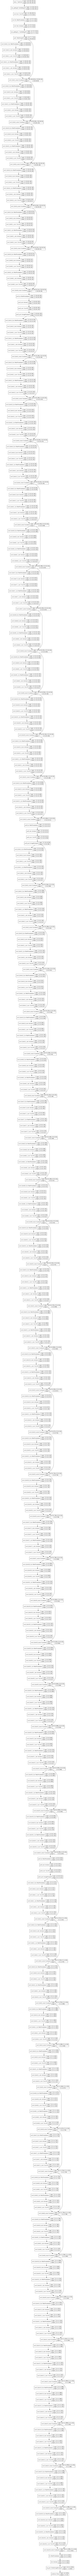

In [ ]:

model = tf.keras.applications.DenseNet121(
    include_top=True, weights = weights, input_tensor=None, input_shape=(150,150,3),
    pooling="max", classes=10
)


inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation


model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Compiling Model And training

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
logdir = os.path.join("/content/gdrive/My Drive/Densenet121/logs-densenet121/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
csv_logger = tf.keras.callbacks.CSVLogger('/content/gdrive/My Drive/Densenet121/densenet121_training.csv',append = True)
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path), tensorboard_callback,csv_logger
]
i = 0
epochs = 8
history = model.fit(train_ds, epochs=epochs,callbacks = callbacks, validation_data=val_ds)

Epoch 1/8
  1/465 [..............................] - ETA: 0s - loss: 9.7905e-05 - accuracy: 1.0000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
142/465 [========>.....................] - ETA: 1:35:42 - loss: 0.0024 - accuracy: 0.9991

# Visualizing Training Data wit Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logdir

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()